In [1]:
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as ss
import xgboost as xgb

In [2]:
# load training data
a_train = pd.read_csv(DATA_PATHS['A']['train'], index_col='id')
b_train = pd.read_csv(DATA_PATHS['B']['train'], index_col='id')
c_train = pd.read_csv(DATA_PATHS['C']['train'], index_col='id')

## Eliminate NaNs

There are some columns which are repleted with nan values. Lets eliminate them

In [3]:
def eliminate_nan_cols(df, threshold=0.4):
    # threshold is the proportion of nans that determines when 
    # a column should be deleted. For example, when 40% of the values
    # are nans
    nan_count = df.isnull().sum() > int(len(df) * threshold)
    values = np.array(nan_count.values)
    cols = np.array(nan_count.index)
    cols = cols[values]
    return df.drop(cols, axis=1)

In [4]:
tr = 0.4
print("A columns before eliminating nans: {}".format(len(a_train.columns.tolist())))
print("B columns before eliminating nans: {}".format(len(b_train.columns.tolist())))
print("C columns before eliminating nans: {}".format(len(c_train.columns.tolist())))

a_train = eliminate_nan_cols(a_train, threshold=tr)
b_train = eliminate_nan_cols(b_train, threshold=tr)
c_train = eliminate_nan_cols(c_train, threshold=tr)

print("A columns after eliminating nans: {}".format(len(a_train.columns.tolist())))
print("B columns after eliminating nans: {}".format(len(b_train.columns.tolist())))
print("C columns after eliminating nans: {}".format(len(c_train.columns.tolist())))

A columns before eliminating nans: 345
B columns before eliminating nans: 442
C columns before eliminating nans: 164
A columns after eliminating nans: 345
B columns after eliminating nans: 436
C columns after eliminating nans: 164


Great, only B had some massive nan columns. Lets proceed to eliminate highly correlated columns

## Eliminating highly correlated columns

We will use Cramer's correlation equation for this

In [5]:
# Lets filter out the columns with high correlation
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def get_corr_matrix(df):
    df_objs = df.select_dtypes(include=['O'])
    del df_objs['country']
    corr_matrix = pd.DataFrame(columns=df_objs.columns, index=df_objs.columns.tolist())
    with tqdm(total=len(corr_matrix.columns.tolist()) * len(corr_matrix.columns.tolist())) as pbar:
        for col1 in df_objs.columns.tolist():
            for col2 in df_objs.columns.tolist():
                if col1 != col2:
                    confusion_matrix = pd.crosstab(df_objs[col1], df_objs[col2])
                    corr = cramers_corrected_stat(confusion_matrix)
                else:
                    corr = 1
                corr_matrix.loc[col1, col2] = corr
                pbar.update(1)
    
    return corr_matrix

def get_correlated_columns(corr_matrix, threshold=0.5):
    cols = {}
    for c1 in corr_matrix.columns.tolist():
        s = corr_matrix.loc[c1]
        s = s[s > threshold]
        s = list(s.index)
        s.remove(c1)
        cols[c1] = s

    cols = {k: cols[k] for k in cols if cols[k]}
    return cols

In [6]:
a_corr_matrix = get_corr_matrix(a_train)
b_corr_matrix = get_corr_matrix(b_train)
c_corr_matrix = get_corr_matrix(c_train)

  0%|          | 0/173889 [00:00<?, ?it/s]/home/eze/.miniconda3/envs/poverty/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 17424/17424 [02:26<00:00, 118.53it/s]


In [7]:
tr = 0.7
a_corr_cols = get_correlated_columns(a_corr_matrix, threshold=tr)
b_corr_cols = get_correlated_columns(b_corr_matrix, threshold=tr)
c_corr_cols = get_correlated_columns(c_corr_matrix, threshold=tr)

In [8]:
# Lets delete the highly correlated columns in a greedy manner
def delete_columns(df, dict_cols):
    to_delete = list(set([elem for values in dict_cols.values() for elem in values]))
    return df.drop(to_delete, axis=1)


a_train_small = delete_columns(a_train, a_corr_cols)
b_train_small = delete_columns(b_train, b_corr_cols)
c_train_small = delete_columns(c_train, c_corr_cols)


print("Columns removed from A: {}".format(len(a_train.columns) - len(a_train_small.columns)))
print("Columns removed from B: {}".format(len(b_train.columns) - len(b_train_small.columns)))
print("Columns removed from C: {}".format(len(c_train.columns) - len(c_train_small.columns)))

Columns removed from A: 61
Columns removed from B: 131
Columns removed from C: 41


In [9]:
a_train_small.head()

,wBXbHZmp,SlDKnCuu,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,sArDRIyX,goxNwvnG,TYhoEiNm,bgfNZfcj,...,QZiSWCCB,sDGibZrP,CsGvKKBJ,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
id,,,,,,,,,,,,,,,,,,,,,
46107,JhtDR,GUusz,ZYabk,feupP,PHMVg,NDTCU,MwLvg,wSMgG,sdlSU,aSGQn,...,wxJis,JqHnW,MaXfS,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A
82739,JhtDR,GUusz,ZYabk,feupP,PHMVg,NDTCU,MwLvg,wSMgG,sdlSU,aSGQn,...,AZwXA,JqHnW,MaXfS,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
9646,JhtDR,GUusz,ZYabk,uxuSS,PHMVg,NDTCU,MwLvg,wSMgG,sdlSU,aSGQn,...,AZwXA,JqHnW,MaXfS,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
10975,JhtDR,GUusz,ZYabk,feupP,PHMVg,NDTCU,MwLvg,wSMgG,sdlSU,aSGQn,...,wxJis,JqHnW,MaXfS,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
16463,JhtDR,alLXR,ZYabk,feupP,PHMVg,NDTCU,MwLvg,wSMgG,sdlSU,aSGQn,...,wxJis,JqHnW,MaXfS,idRwx,UyAms,vkbkA,qQxrL,GAZGl,aQeIm,A


## Check correlation between remaining columns and 'poor' label

In [10]:
def get_poor_correlation(df):
    df_objs = df.columns.tolist()
    df_objs.remove('poor')
    corr_matrix = pd.DataFrame(columns=['poor'], index=df_objs)
    with tqdm(total=len(df_objs)) as pbar:
        for col in df_objs:
            confusion_matrix = pd.crosstab(df['poor'], df[col])
            corr = cramers_corrected_stat(confusion_matrix)
            corr_matrix.loc[col, 'poor'] = corr
            pbar.update(1)
    return corr_matrix

In [11]:
a_corr_poor = get_poor_correlation(a_train_small)
b_corr_poor = get_poor_correlation(b_train_small)
c_corr_poor = get_poor_correlation(c_train_small)

 94%|█████████▎| 265/283 [00:01<00:00, 189.14it/s]/home/eze/.miniconda3/envs/poverty/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 122/122 [00:00<00:00, 171.50it/s]


In [24]:
a_corr_poor.head()

,poor
wBXbHZmp,0.0987969
SlDKnCuu,0.109241
DsKacCdL,0.203108
rtPrBBPl,0.131487
tMJrvvut,0.0973909


In [18]:
a_useful_cols = a_corr_poor[a_corr_poor['poor'] > 0.1].index.tolist() + ['poor']
len(a_useful_cols)

125

In [23]:
b_corr_poor.head()

,poor
RzaXNcgd,0.0355971
LfWEhutI,0.040955
jXOqJdNL,0
wJthinfa,0.140366
ZvEApWrk,0


In [25]:
b_useful_cols = b_corr_poor[b_corr_poor['poor'] > 0.05].index.tolist() + ['poor']
len(b_useful_cols)

99

In [26]:
c_corr_poor.head()

,poor
GRGAYimk,0.246692
cNDTCUPU,0.0349118
GvTJUYOo,0.0418462
vmKoAlVH,0.153688
LhUIIEHQ,0.253868


In [27]:
c_useful_cols = c_corr_poor[c_corr_poor['poor'] > 0.1].index.tolist() + ['poor']
len(c_useful_cols)

73

Lets work with those columns only:

In [28]:
a_train_small = a_train_small[a_useful_cols + ['country']]
b_train_small = b_train_small[b_useful_cols + ['country']]
c_train_small = c_train_small[c_useful_cols + ['country']]

## Plot columns values distribution

In [29]:
def get_object_columns(df):
    obj = df.select_dtypes(include=['O'])
    del obj['country']
    return obj


def get_numeric_columns(df):
    obj = df.select_dtypes(include=['int64', 'float64'])
    return obj


def convert_objs_to_cat(df):
    """
    df must contain only Object columns
    """
    tmp = df.copy()
    for col in tmp.columns.tolist():
        tmp[col] = tmp[col].astype('category')
    tmp[tmp.columns.tolist()] = tmp[tmp.columns.tolist()].apply(lambda x: x.cat.codes)
    return tmp

In [30]:
ay_train = a_train_small.poor
a_train_objs = get_object_columns(a_train_small)
a_train_nums = get_numeric_columns(a_train_small)
a_train_cats = convert_objs_to_cat(a_train_objs)

by_train = b_train_small.poor
b_train_objs = get_object_columns(b_train_small)
b_train_nums = get_numeric_columns(b_train_small)
b_train_cats = convert_objs_to_cat(b_train_objs)

cy_train = c_train_small.poor
c_train_objs = get_object_columns(c_train_small)
c_train_nums = get_numeric_columns(c_train_small)
c_train_cats = convert_objs_to_cat(c_train_objs)

In [31]:
def visualize_grassi(x, y):
    # Violin visualization
    data_n_2 = (x - x.mean()) / (x.std())
    data = pd.concat([y, data_n_2],axis=1)
    data = pd.melt(data,id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="poor", data=data, split=True, inner="quart")
    plt.xticks(rotation=90)

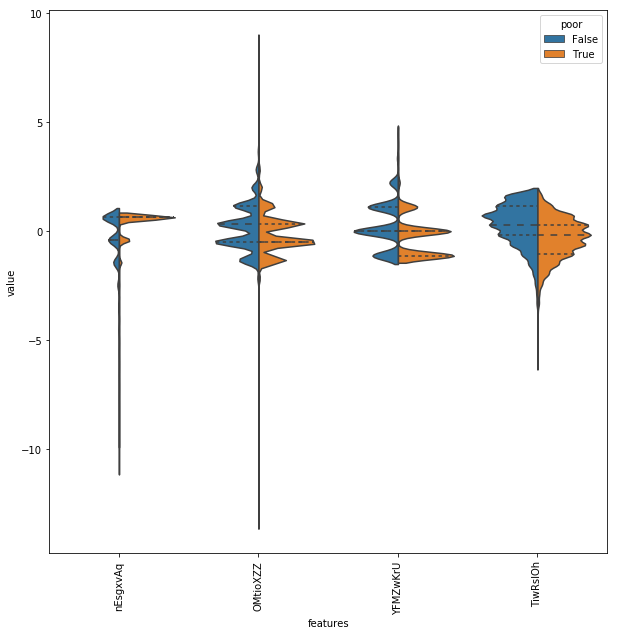

In [32]:
visualize_grassi(a_train_nums, ay_train)

In [33]:
def visualize_grassi_cate(x, y):
    data = pd.concat([y, x],axis=1)
    data = pd.melt(data, id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="poor", data=data, split=True)
    plt.xticks(rotation=90)

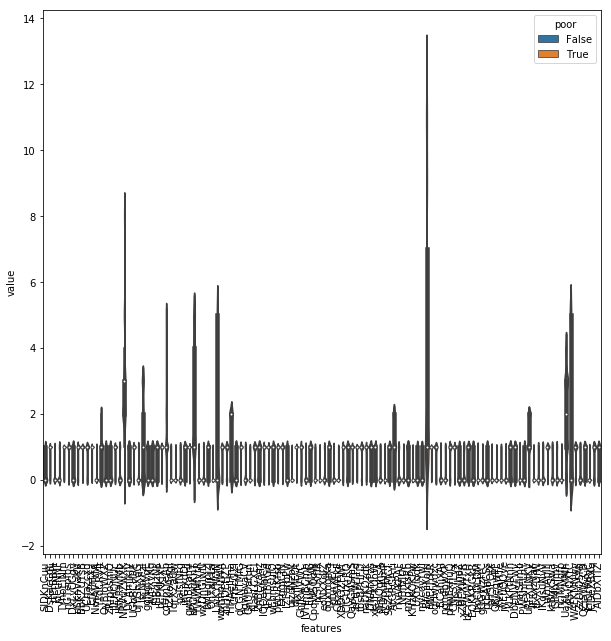

In [34]:
visualize_grassi_cate(a_train_cats, ay_train)

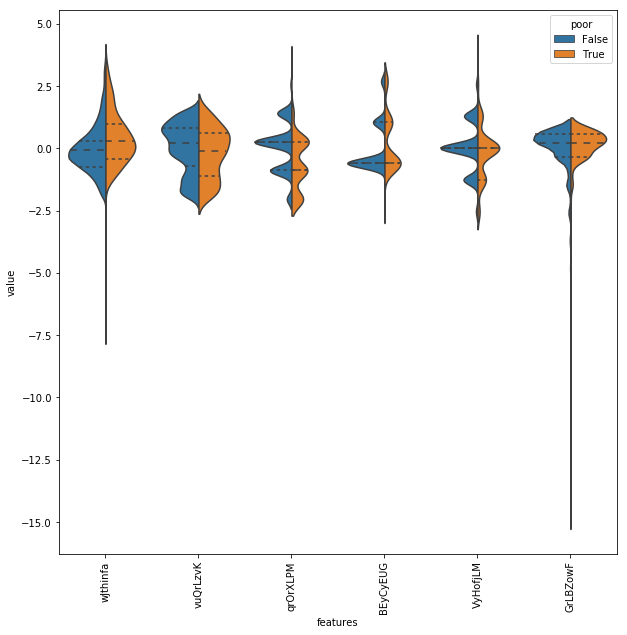

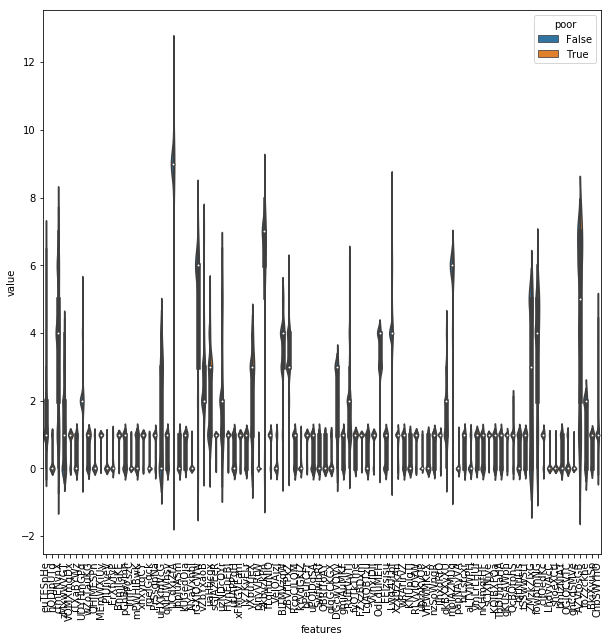

In [35]:
visualize_grassi(b_train_nums, by_train)
visualize_grassi_cate(b_train_cats, by_train)

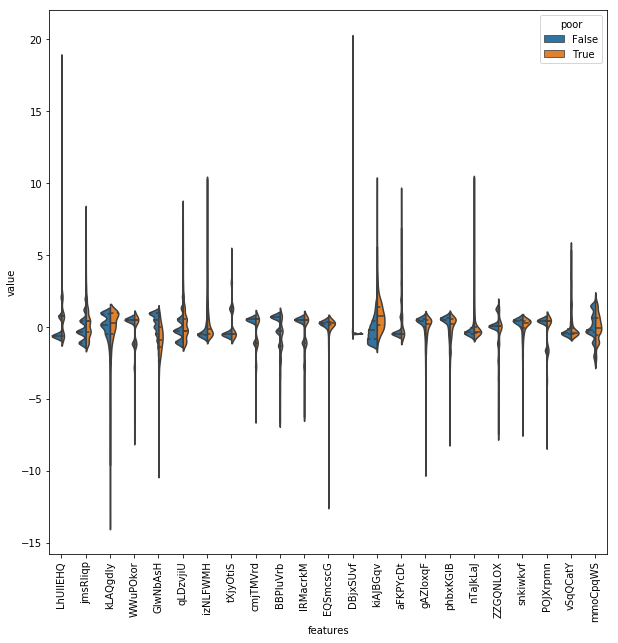

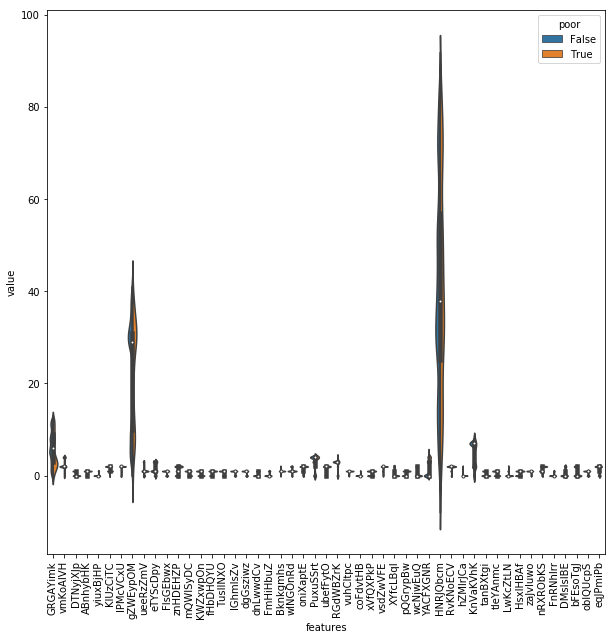

In [36]:
visualize_grassi(c_train_nums, cy_train)
visualize_grassi_cate(c_train_cats, cy_train)

Not sure if there are significant differences visually speaking, but they certainly don't look the same. Lets print the columns so we can work with them in our training script:

In [38]:
print("a_hhold_keep_cols = {}".format(a_train_small.columns.tolist()))
print("b_hhold_keep_cols = {}".format(b_train_small.columns.tolist()))
print("c_hhold_keep_cols = {}".format(c_train_small.columns.tolist()))

a_hhold_keep_cols = ['SlDKnCuu', 'DsKacCdL', 'rtPrBBPl', 'jdetlNNF', 'TYhoEiNm', 'nGTepfos', 'DxLvCGgv', 'uSKnVaKV', 'BbKZUYsB', 'UCnazcxd', 'EfkPrfXa', 'nEsgxvAq', 'NmAVTtfA', 'YTdCRVJt', 'QyBloWXZ', 'ZRrposmO', 'IIEHQNUc', 'HfKRIwMb', 'NRVuZwXK', 'UCAmikjV', 'UGbBCHRE', 'uJYGhXqG', 'ltcNxFzI', 'ggNglVqE', 'JwtIxvKg', 'FlBqizNL', 'bEPKkJXP', 'cqUmYeAp', 'tZKoAqgl', 'TqrXZaOw', 'galsfNtg', 'ihGjxdDj', 'gwhBRami', 'bPOwgKnT', 'YWwNfVtR', 'wxDnGIwN', 'bMudmjzJ', 'OnTaJkLa', 'OMtioXZZ', 'LjvKYNON', 'wwfmpuWA', 'znHDEHZP', 'HHAeIHna', 'CrfscGZl', 'dCGNTMiG', 'ngwuvaCV', 'GnUDarun', 'NanLCXEI', 'ZnBLVaqz', 'lQQeVmCa', 'lFcfBRGd', 'wEbmsuJO', 'pWyRKfsb', 'ErggjCIN', 'IZFarbPw', 'YFMZwKrU', 'uizuNzbk', 'dlyiMEQt', 'GhJKwVWC', 'lVHmBCmb', 'EuJrVjyG', 'CpqWSQcW', 'jxSUvflR', 'eoNxXdlZ', 'qgxmqJKa', 'gfurxECf', 'CbzSWtkF', 'XDDOZFWf', 'CIGUXrRQ', 'QayGNSmS', 'ePtrWTFd', 'tbsBPHFD', 'naDKOzdk', 'DNAfxPzs', 'xkUFKUoW', 'dEpQghsA', 'jVDpuAmP', 'SeZULMCT', 'AtGRGAYi', 'rYvVKPAF', 'NBfffJUe', 'mvgxfs